In [1]:
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test, multivariate_logrank_test, pairwise_logrank_test
import matplotlib.pyplot as plt

# set seed for reproducibility
np.random.seed(1337)


In [2]:
# read colon dataset
data = pd.read_csv('colon.csv')
data = data[data['etype'] == 2]
data = data.drop(['etype'], axis=1)
data['age_group'] = pd.qcut(data['age'], 3, labels=['low', 'medium', 'high'])
data = data.dropna()
data['differ'] = data['differ'].astype(int)
data['nodes'] = data['nodes'].astype(int)
data.head()

,Unnamed: 0,id,study,rx,sex,age,obstruct,perfor,adhere,nodes,status,differ,extent,surg,node4,time,age_group
0,1,1,1,Lev+5FU,1,43,0,0,0,5,1,2,3,0,1,1521,low
2,3,2,1,Lev+5FU,1,63,0,0,0,1,0,2,3,0,0,3087,medium
4,5,3,1,Obs,0,71,0,0,1,7,1,2,2,0,1,963,high
6,7,4,1,Lev+5FU,0,66,1,0,0,6,1,2,3,1,1,293,medium
8,9,5,1,Obs,1,69,0,0,0,22,1,2,3,1,1,659,high


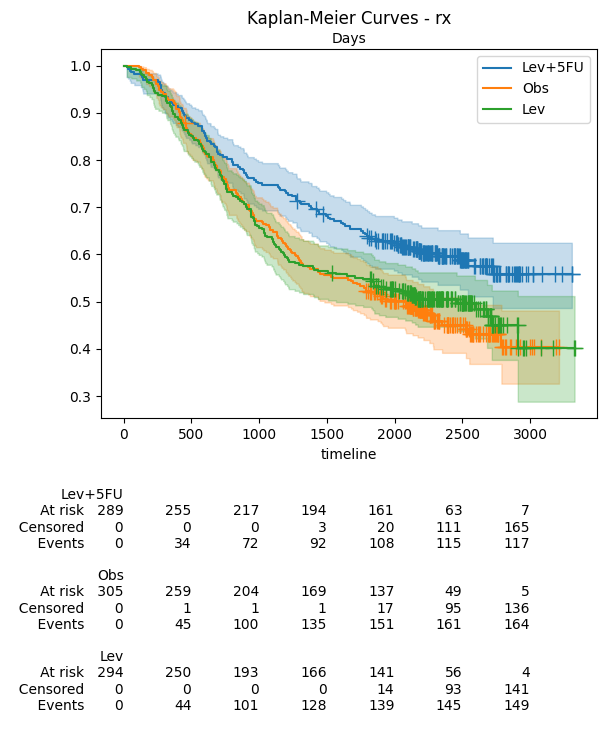

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          11.02 <0.005      7.95

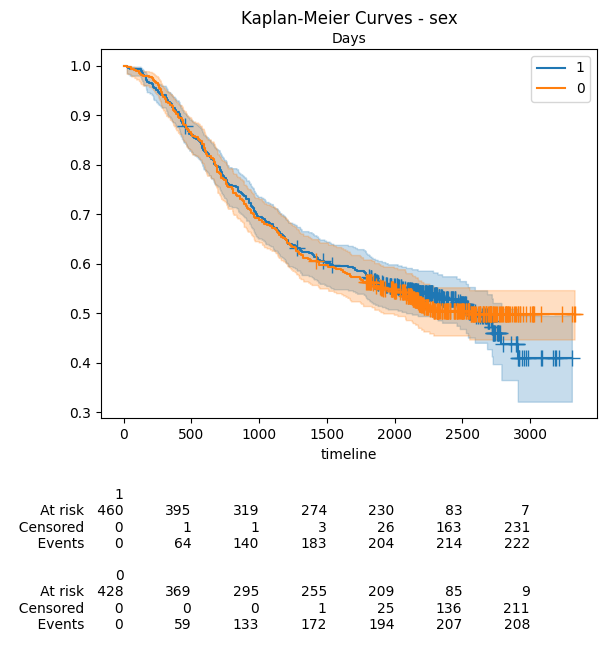

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           0.01 0.94      0.10

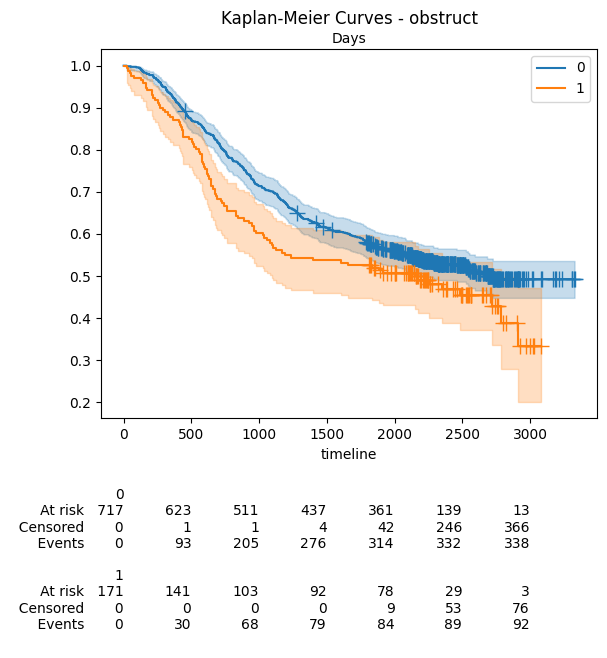

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           4.50 0.03      4.88

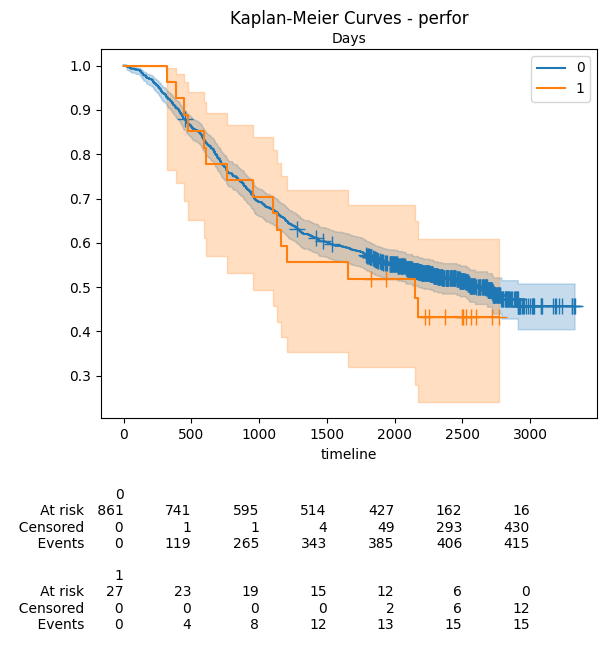

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           0.38 0.54      0.90

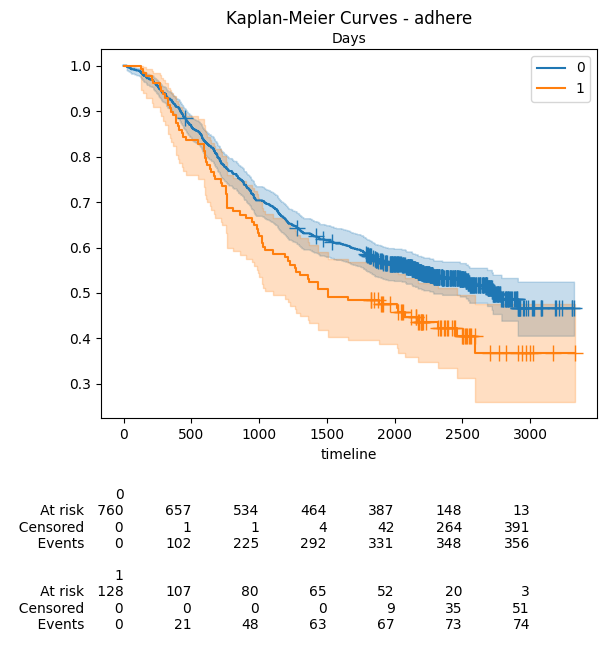

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           5.68 0.02      5.87

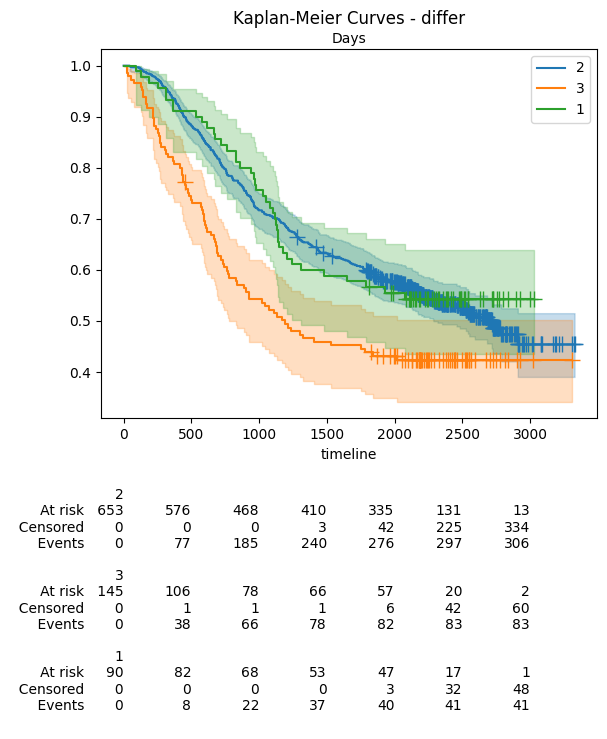

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          13.44 <0.005      9.69

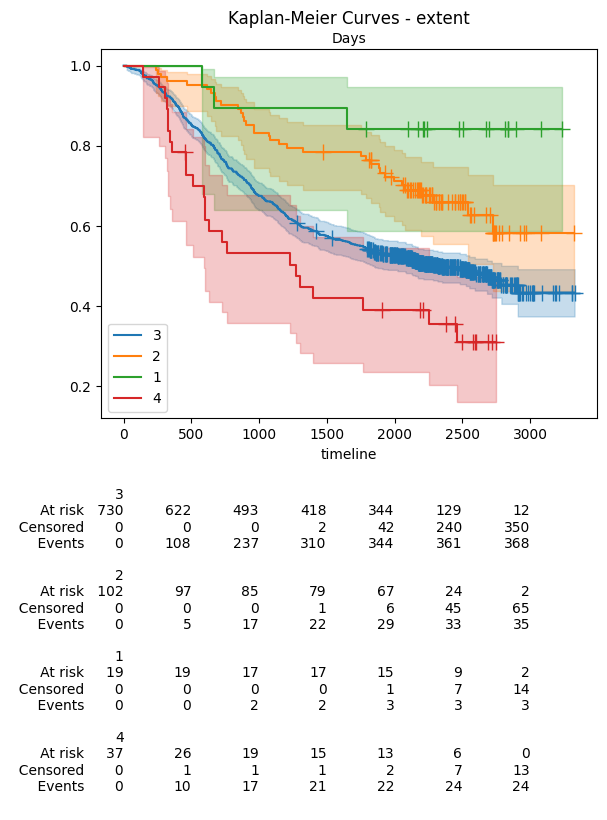

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          24.23 <0.005     15.45

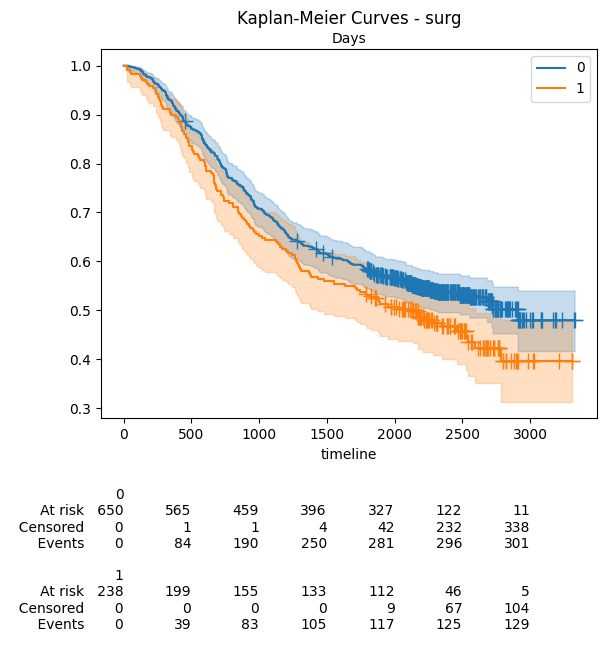

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           3.98 0.05      4.44

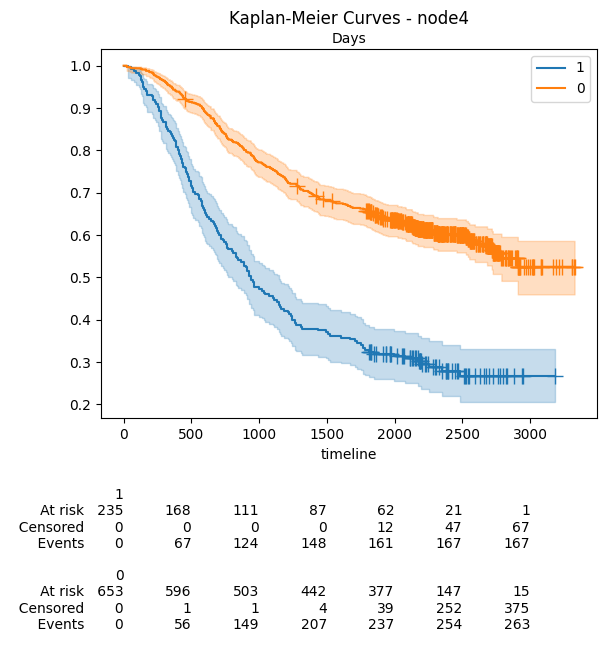

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          99.45 <0.005     75.39

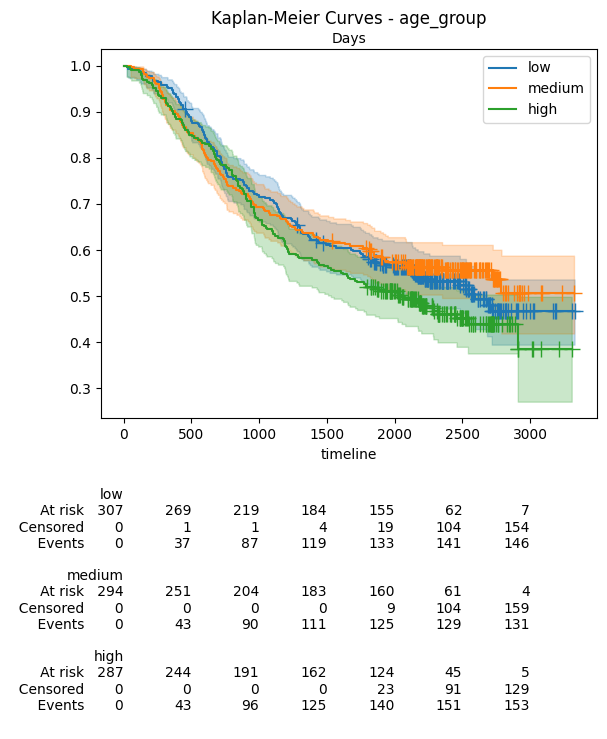

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           3.90 0.14      2.81

In [3]:
#Kaplan-Meier Curves for different treatments


#Kaplan-Meier Curves for different treatments
for column in data.columns[1:]:
    if column in ['id', 'study', 'time', 'status', 'nodes', 'age']:
        continue
    fig, ax = plt.subplots()
    list_models = []
    # fit and plot KM for each treatment group
    for treatment in data[column].unique():
        ix = data[column] == treatment
        kmf = KaplanMeierFitter()
        kmf.fit(data['time'][ix], data['status'][ix], label=treatment)
        kmf.plot(ax=ax, show_censors=True)
        list_models.append(kmf)
    add_at_risk_counts(*list_models)

    # set title according to column name
    plt.title(f'Kaplan-Meier Curves - {column}')
    plt.xlabel('Days')
    plt.ylabel('Survival Probability')
    plt.show()

    # If there are more than two groups, use the pairwise_logrank_test function
    results = multivariate_logrank_test(data['time'], data[column], data['status'])
    results.print_summary()

Q1

In this Kaplan-Meier (KM) analysis of the colon cancer trial data, certain factors demonstrated significant impacts on patient survival. Treatment type (rx), obstruction (obstruct), adherence to nearby organs (adhere), tumour differentiation (differ), extent of local spread (extent), time from surgery to registration (surg), and the presence of more than four positive lymph nodes (node4) emerged as significant, with p-values at or below the 0.05 threshold. This suggests a strong link between these factors and survival outcomes in colon cancer patients receiving adjuvant chemotherapy.

On the other hand, age group, perforation of the colon (perfor), and sex did not show statistical significance in our KM curves. However, it's crucial to note that these factors might still hold valuable insights.

Just by looking at the plots it is very clear that node4 will be a very important feature in further analysis, as in this the lines are very seperable.

Q2:

The Kaplan-Meier curves for 'sex' and 'obstruction' suggest potential violations of the proportional hazards assumption. These curves experiences "dips", indicating a change in hazard rate.

## Task 2

In [4]:
data_cox = data.copy()

# drop age and age_group
data_cox = data_cox.drop(['age', 'age_group'], axis=1)

# remove nan
data_cox = data_cox.dropna()

# Splitting up the treatment as there is no clear ordering
data_cox = pd.get_dummies(data_cox, drop_first=True)
data_cox.info()



<class 'pandas.core.frame.DataFrame'>
Index: 888 entries, 0 to 1856
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  888 non-null    int64
 1   id          888 non-null    int64
 2   study       888 non-null    int64
 3   sex         888 non-null    int64
 4   obstruct    888 non-null    int64
 5   perfor      888 non-null    int64
 6   adhere      888 non-null    int64
 7   nodes       888 non-null    int32
 8   status      888 non-null    int64
 9   differ      888 non-null    int32
 10  extent      888 non-null    int64
 11  surg        888 non-null    int64
 12  node4       888 non-null    int64
 13  time        888 non-null    int64
 14  rx_Lev+5FU  888 non-null    bool 
 15  rx_Obs      888 non-null    bool 
dtypes: bool(2), int32(2), int64(12)
memory usage: 98.9 KB


In [5]:
from lifelines import CoxPHFitter
cox_columns = ['time', 'status', 'rx_Lev+5FU', 'rx_Obs', 'sex', 'obstruct', 'perfor', 'adhere', 'nodes', 'differ', 'extent', 'surg', 'node4']
temp_cox = data_cox[cox_columns]

# Fit the Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(temp_cox, duration_col='time', event_col='status')

# Print the summary of the model
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 888 total observations, 458 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 888
number of events observed = 430
   partial log-likelihood = -2699.76
         time fit was run = 2023-11-27 17:04:50 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
rx_Lev+5FU  -0.31       0.73       0.12            -0.56            -0.07                 0.57                 0.93
rx_Obs       0.04       1.04       0.11            -0.18             0.26                 0.83                 1.30
sex          0.00       1.00       0.10            -0.19             0.19                 0.83                 1.21
obstruct     0.25       1.28       0.12             0.01             0.48                 1.01                 1.62
perfor      -0.02       0.98       0.27            -0.54             0.51                 0.58                 1.67
adhere       0.20       1.22       0.13            -0.06             0.45                 0.94                 1.57
nodes        0.04       1.04       0.02             0.01             0.07                 1.01                 1.08
differ       0.14       1.15       0.10            -0.06             0.34                 0.95                 1.40
extent       0.44       1.56       0.12             0.21             0.68                 1.24                 1.97
surg         0.25       1.28       0.11             0.04             0.46                 1.04                 1.58
node4        0.66       1.93       0.14             0.38             0.93                 1.46                 2.55

             cmp to     z      p   -log2(p)
covariate                                  
rx_Lev+5FU     0.00 -2.53   0.01       6.43
rx_Obs         0.00  0.34   0.73       0.45
sex            0.00  0.01   0.99       0.02
obstruct       0.00  2.05   0.04       4.64
perfor         0.00 -0.06   0.95       0.07
adhere         0.00  1.50   0.13       2.91
nodes          0.00  2.88 <0.005       7.98
differ         0.00  1.40   0.16       2.63
extent         0.00  3.75 <0.005      12.46
surg           0.00  2.33   0.02       5.67
node4          0.00  4.63 <0.005      18.03
---
Concordance = 0.67
Partial AIC = 5421.52
log-likelihood ratio test = 136.30 on 11 df
-log2(p) of ll-ratio test = 76.53

played around a bit and found the following to get the best result. Not a whole lot better, but AIC is a bit lower.

In [6]:
#cox_columns = ['time', 'status', 'rx_Lev+5FU', 'obstruct', 'adhere', 'nodes', 'differ', 'extent', 'surg', 'node4']
# make a negative selection of columns
cox_columns = data_cox.columns.drop(['Unnamed: 0','id', 'study', 'sex', 'perfor', 'rx_Obs'])
temp_cox = data_cox[cox_columns]

# Fit the Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(temp_cox, duration_col='time', event_col='status')

# Print the summary of the model
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 888 total observations, 458 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 888
number of events observed = 430
   partial log-likelihood = -2699.82
         time fit was run = 2023-11-27 17:04:50 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
obstruct     0.25       1.28       0.12             0.02             0.48                 1.02                 1.62
adhere       0.19       1.22       0.13            -0.06             0.45                 0.94                 1.57
nodes        0.04       1.04       0.02             0.01             0.07                 1.01                 1.08
differ       0.14       1.15       0.10            -0.05             0.34                 0.95                 1.41
extent       0.44       1.56       0.12             0.21             0.68                 1.24                 1.97
surg         0.25       1.28       0.11             0.04             0.46                 1.04                 1.58
node4        0.66       1.93       0.14             0.38             0.94                 1.47                 2.55
rx_Lev+5FU  -0.34       0.72       0.11            -0.55            -0.12                 0.58                 0.89

             cmp to     z      p   -log2(p)
covariate                                  
obstruct       0.00  2.10   0.04       4.79
adhere         0.00  1.50   0.13       2.92
nodes          0.00  2.87 <0.005       7.92
differ         0.00  1.43   0.15       2.71
extent         0.00  3.75 <0.005      12.46
surg           0.00  2.36   0.02       5.78
node4          0.00  4.67 <0.005      18.37
rx_Lev+5FU     0.00 -3.07 <0.005       8.89
---
Concordance = 0.67
Partial AIC = 5415.64
log-likelihood ratio test = 136.18 on 8 df
-log2(p) of ll-ratio test = 82.49

Q3

The CoxPH model effectively identifies key factors influencing survival outcomes in colon cancer patients. The model, analyzed on 888 observations with 430 events, shows several significant covariates. Notably, 'node4' (HR=1.93) and 'extent' (HR=1.56) are highly significant (p<0.005), indicating that patients with more than four positive lymph nodes and extensive local spread of the tumor have considerably higher risks. The treatment 'rx_Lev+5FU' shows a protective effect with a hazard ratio of 0.72, suggesting a reduced risk of the event occurring in patients receiving this treatment.

Other significant factors include 'obstruct' (HR=1.28), 'surg' (HR=1.28), and 'nodes' (HR=1.04). The model’s concordance index of 0.67 and a log-likelihood ratio test value of 136.18 on 8 degrees of freedom indicate a good fit. These results highlight the complex interplay of various clinical features in predicting survival, with particular emphasis on lymph node involvement, tumor spread, and treatment type.

Q4

The CoxPH model's results correlate well with the KM curves from Task 1. Both analyses emphasize the significance of spread to multple nymph nodes('node4') and tumor spread ('extent') in affecting survival outcomes. The KM curves likely showed distinct separation in survival probabilities for patients based on these factors, which is quantitatively supported by the hazard ratios in the CoxPH model. The protective effect of 'rx_Lev+5FU' in the CoxPH model may also align with better survival curves for patients receiving this treatment in the KM analysis. This consistency between the CoxPH model and KM curves underscores the robustness of the findings across different analytical methods.

# Task 3

In [7]:
import numpy as np
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Assuming 'data' is your DataFrame and 'y' is the structured array with event and time
# Example: y = data[['status', 'time']].to_records(index=False)
X = data_cox.drop(['time', 'status', 'id', 'Unnamed: 0', 'study'], axis=1)

# convert y to structured array with time as int
y = data_cox[['status', 'time']].to_records(index=False)
y = np.array(y.tolist(), dtype=np.dtype([('status', '?'), ('time', '<f8')]))

X.head()

,sex,obstruct,perfor,adhere,nodes,differ,extent,surg,node4,rx_Lev+5FU,rx_Obs
0,1,0,0,0,5,2,3,0,1,True,False
2,1,0,0,0,1,2,3,0,0,True,False
4,0,0,0,1,7,2,2,0,1,False,True
6,0,1,0,0,6,2,3,1,1,True,False
8,1,0,0,0,22,2,3,1,1,False,True


In [8]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import integrated_brier_score, concordance_index_censored
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer

# remove warnings
import warnings
warnings.filterwarnings('ignore')

# Define concordance index as metric
def conc_score(y, y_pred): 
    conc = concordance_index_censored(y["status"], y["time"], y_pred)[0]
    return conc

concordance_metric = make_scorer(conc_score, greater_is_better=True)

# Stratify by censoring status
stratified_kfold = StratifiedKFold(n_splits=4)

# Initialize models
cox_model = CoxPHSurvivalAnalysis()
rsf_model = RandomSurvivalForest()

# Lists to store metrics
cox_metrics = {'params': [], 'brier_score': [], 'c_index': [], 'permutation_importance': []}
rsf_metrics = {'params': [], 'brier_score': [], 'c_index': [], 'permutation_importance': []}

# Cross-validation
for train_idx, test_idx in stratified_kfold.split(X, y):
    lower, upper = np.percentile(y[train_idx]["time"], [10, 90])
    times = np.arange(lower, upper + 1)

    # scale X
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X.iloc[train_idx])
    X_test = scaler.transform(X.iloc[test_idx])

    # grid search
    cox_params = {'alpha': np.logspace(-5, 5, 10)}
    rsf_params = {'n_estimators': [10, 50, 100, 200, 500], 'max_depth': [1, 2, 4, 5, None]}

    cox_grid = GridSearchCV(cox_model, cox_params, scoring=concordance_metric)
    rsf_grid = GridSearchCV(rsf_model, rsf_params, scoring=concordance_metric)

    # gird search with concordance index as scoring
    cox_grid.fit(X_train, y[train_idx])
    rsf_grid.fit(X_train, y[train_idx])


    cox_model.set_params(**cox_grid.best_params_)
    rsf_model.set_params(**rsf_grid.best_params_)

    # append best params
    cox_metrics['params'].append(cox_grid.best_params_)
    rsf_metrics['params'].append(rsf_grid.best_params_)

    # fit models
    cox_model.fit(X_train, y[train_idx])
    rsf_model.fit(X_train, y[train_idx])

    # predict
    cox_pred = cox_model.predict(X_test)
    rsf_pred = rsf_model.predict(X_test)

    # predict survival function
    cox_surv_probs = cox_model.predict_survival_function(X_test)
    rsf_surv_probs = rsf_model.predict_survival_function(X_test)

    cox_preds = np.asarray([fn(times) for fn in cox_surv_probs])
    rsf_preds = np.asarray([fn(times) for fn in rsf_surv_probs])

    # find the features that are important

    # evaluate
    cox_metrics['brier_score'].append(integrated_brier_score(y[train_idx], y[test_idx], cox_preds, times))
    cox_metrics['c_index'].append(concordance_index_censored(y[test_idx]['status'], y[test_idx]['time'], cox_pred)[0])
    cox_metrics['permutation_importance'].append(permutation_importance(cox_model, X_test, y[test_idx], n_repeats=10, random_state=42))

    rsf_metrics['brier_score'].append(integrated_brier_score(y[train_idx], y[test_idx], rsf_preds, times))
    rsf_metrics['c_index'].append(concordance_index_censored(y[test_idx]['status'], y[test_idx]['time'], rsf_pred)[0])
    rsf_metrics['permutation_importance'].append(permutation_importance(rsf_model, X_test, y[test_idx], n_repeats=10, random_state=42))
   

In [9]:
# Print results, both mean and standard deviation¨
print('CoxPH:')
print('params: {}'.format(cox_metrics['params']))
print('Brier Score: {:.3f} +/- {:.3f}'.format(np.mean(cox_metrics['brier_score']),
                                               np.std(cox_metrics['brier_score'])))
print('C-Index: {:.3f} +/- {:.3f}'.format(np.mean(cox_metrics['c_index']),
                                             np.std(cox_metrics['c_index'])))
print('Permutation feature importance:')
# find permutation the mean permutation importance across all elements in the list aswell as std
cox_means = np.mean([i['importances_mean'] for i in cox_metrics['permutation_importance']], axis=0)
cox_std = np.mean([i['importances_std'] for i in cox_metrics['permutation_importance']], axis=0)
# zip X.columns with the mean and std
sorted_inx = cox_means.argsort()
for i in zip(X.columns, cox_means, cox_std):
    print('{}: {:.3f} +/- {:.3f}'.format(i[0], i[1], i[2]))


CoxPH:
params: [{'alpha': 7742.636826811277}, {'alpha': 599.4842503189421}, {'alpha': 100000.0}, {'alpha': 100000.0}]
Brier Score: 0.216 +/- 0.012
C-Index: 0.655 +/- 0.012
Permutation feature importance:
sex: -0.001 +/- 0.001
obstruct: 0.003 +/- 0.004
perfor: -0.001 +/- 0.001
adhere: 0.005 +/- 0.005
nodes: 0.030 +/- 0.012
differ: 0.002 +/- 0.006
extent: 0.022 +/- 0.008
surg: 0.004 +/- 0.004
node4: 0.035 +/- 0.011
rx_Lev+5FU: 0.009 +/- 0.007
rx_Obs: -0.000 +/- 0.004


In [10]:
print('\nRandom Survival Forest:')
print('params: {}'.format(rsf_metrics['params']))
print('Brier Score: {:.3f} +/- {:.3f}'.format(np.mean(rsf_metrics['brier_score']),
                                               np.std(rsf_metrics['brier_score'])))
print('C-Index: {:.3f} +/- {:.3f}'.format(np.mean(rsf_metrics['c_index']),
                                                np.std(rsf_metrics['c_index'])))
print('Permutation Importance:')
rsf_means = np.mean([i['importances_mean'] for i in rsf_metrics['permutation_importance']], axis=0)
for i, j in zip(X.columns, rsf_means):
    print(f"{i}: {j}")
# print 3 most important features
print('\n3 most important features:')
print('CoxPH: {}'.format([X.columns[i] for i in np.argsort(cox_means)[::-1][:3]]))
print('RSF: {}'.format([X.columns[i] for i in np.argsort(rsf_means)[::-1][:3]]))

# print 3 least important features
print('\n3 least important features:')
print('CoxPH: {}'.format([X.columns[i] for i in np.argsort(cox_means)[:3]]))
print('RSF: {}'.format([X.columns[i] for i in np.argsort(rsf_means)[:3]]))


Random Survival Forest:
params: [{'max_depth': 2, 'n_estimators': 200}, {'max_depth': 4, 'n_estimators': 50}, {'max_depth': 4, 'n_estimators': 200}, {'max_depth': 5, 'n_estimators': 500}]
Brier Score: 0.199 +/- 0.005
C-Index: 0.656 +/- 0.015
Permutation Importance:
sex: 0.0018028473072335765
obstruct: 0.000800364905006093
perfor: 0.00013615111606989636
adhere: 0.005329094381575211
nodes: 0.048313871895536306
differ: 0.0058397999055418955
extent: 0.0192736342483893
surg: 0.0038101687019705508
node4: 0.027986973527782774
rx_Lev+5FU: 0.008724903976681572
rx_Obs: -0.0005240573794274895

3 most important features:
CoxPH: ['node4', 'nodes', 'extent']
RSF: ['nodes', 'node4', 'extent']

3 least important features:
CoxPH: ['sex', 'perfor', 'rx_Obs']
RSF: ['rx_Obs', 'perfor', 'obstruct']


Q5:

The CoxPH model, with a Brier score of 0.216 and a C-index of 0.655, highlights 'node4', 'nodes', and 'extent' as the most important features. This suggests that the number and extent of lymph node involvement are critical in determining survival. The RSF model, with a slightly better Brier score of 0.199 and a comparable C-index of 0.656, also identifies 'nodes', 'node4', and 'extent' as significant, reinforcing the findings of the CoxPH model. 

For the CoxPH model it seems like high alpha values were prefered in each fold, meaning that we used quite alot of regularisation. With the Survival forest more varying in its features, using a good mix of the various n_estimators and max_depth  tested.

Q6:

There has been an agreement through all the ways we have looked as this data that 'node4', 'nodes' and 'extent' are all valuable in the amount of information they carry. As they have been selected as the most important features in the scikit-survival models, the lifelines cox proportional hazard and in the KM curves(not nodes as this was not modeled there).

We can also see that 'sex', and 'perfor' and 'rx_Obs' was regarded as insignificant features, and this corresponds to the finds in task 2 where we removed them from the model.

When it came to concordance, the sckikit-survival models performed worse than the lifelines CoxPH model.


